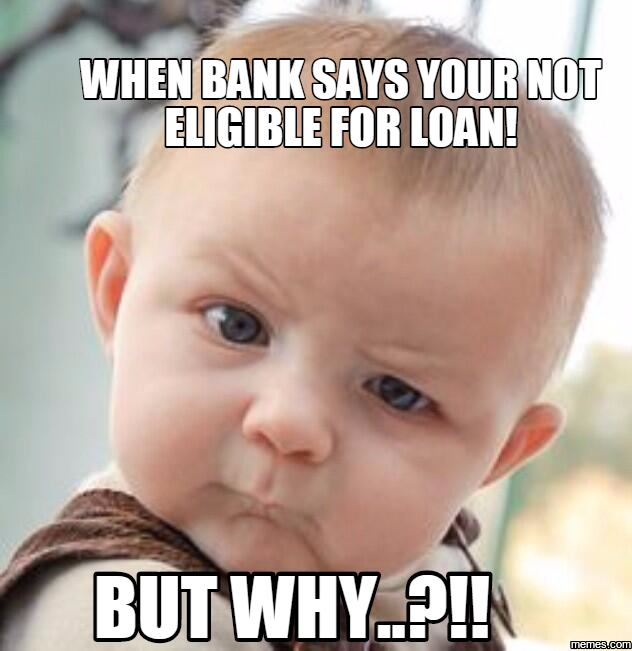
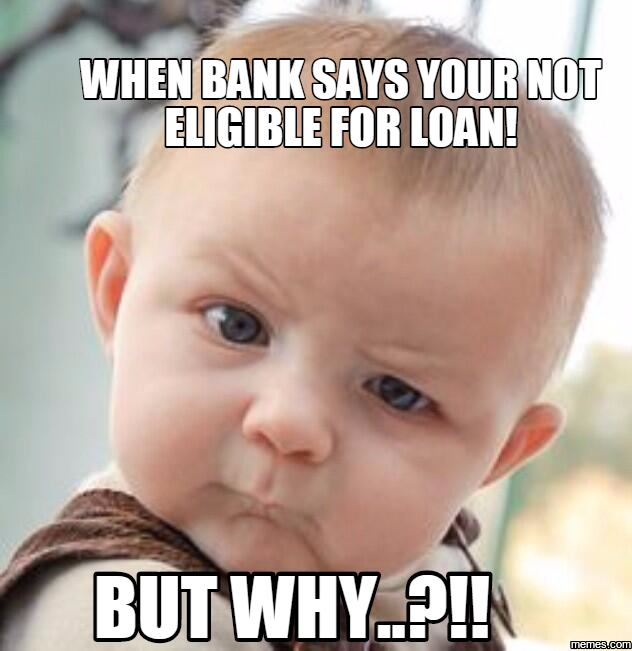

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FunctionTransformer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col='id')
test  = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col='id')
sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [3]:
original = pd.read_csv('/kaggle/input/ps4e9-original-data-loan-approval-prediction/credit_risk_dataset.csv')

In [4]:
train = pd.concat([train, original],axis=0)

In [5]:
train.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
test.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
id,,,,,,,,,,,
58645,23,69000,RENT,3.0,HOMEIMPROVEMENT,F,25000,15.76,0.36,N,2
58646,26,96000,MORTGAGE,6.0,PERSONAL,C,10000,12.68,0.10,Y,4
58647,26,30000,RENT,5.0,VENTURE,E,4000,17.19,0.13,Y,2
58648,33,50000,RENT,4.0,DEBTCONSOLIDATION,A,7000,8.90,0.14,N,7
58649,26,102000,MORTGAGE,8.0,HOMEIMPROVEMENT,D,15000,16.32,0.15,Y,4


In [7]:
train.duplicated().sum()

165

In [8]:
train = train.drop_duplicates()

In [9]:
test.duplicated().sum()

0

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91061 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91061 non-null  int64  
 1   person_income               91061 non-null  int64  
 2   person_home_ownership       91061 non-null  object 
 3   person_emp_length           90174 non-null  float64
 4   loan_intent                 91061 non-null  object 
 5   loan_grade                  91061 non-null  object 
 6   loan_amnt                   91061 non-null  int64  
 7   loan_int_rate               87966 non-null  float64
 8   loan_percent_income         91061 non-null  float64
 9   cb_person_default_on_file   91061 non-null  object 
 10  cb_person_cred_hist_length  91061 non-null  int64  
 11  loan_status                 91061 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39098 entries, 58645 to 97742
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  39098 non-null  int64  
 1   person_income               39098 non-null  int64  
 2   person_home_ownership       39098 non-null  object 
 3   person_emp_length           39098 non-null  float64
 4   loan_intent                 39098 non-null  object 
 5   loan_grade                  39098 non-null  object 
 6   loan_amnt                   39098 non-null  int64  
 7   loan_int_rate               39098 non-null  float64
 8   loan_percent_income         39098 non-null  float64
 9   cb_person_default_on_file   39098 non-null  object 
 10  cb_person_cred_hist_length  39098 non-null  int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 3.6+ MB


In [12]:
train.describe(include="number")

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,91061.000000,9.106100e+04,90174.000000,91061.000000,87966.000000,91061.000000,91061.000000,91061.000000
mean,27.620683,6.477432e+04,4.732306,9351.508352,10.791001,0.163158,5.812752,0.169546
std,6.150047,4.792286e+04,4.025893,5848.017127,3.109323,0.097486,4.039820,0.375235
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.000000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.700000e+04,4.000000,8000.000000,10.950000,0.140000,4.000000,0.000000
75%,30.000000,7.800000e+04,7.000000,12000.000000,13.110000,0.220000,8.000000,0.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [13]:
train.describe(include="O")

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,91061,91061,91061,91061
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,46972,18682,31687,76629


In [14]:
train.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
loan_status                      0
dtype: int64

In [15]:
train['person_emp_length'].fillna(train['person_emp_length'].mean(), inplace=True)
train['loan_int_rate'].fillna(train['loan_int_rate'].mean(), inplace=True)

In [16]:
def feature_engineering(df):
    df['income_to_loan_ratio'] = df['person_income'] / df['loan_amnt']
    df['employment_stability'] = df['person_emp_length'] * df['person_income']
    df['loan_int_rate_category'] = pd.cut(df['loan_int_rate'], bins=[0, 10, 15, 30], labels=['Low', 'Medium', 'High'])
    df['cred_hist_length_category'] = pd.cut(df['cb_person_cred_hist_length'], bins=[0, 5, 10, 15, 30], labels=['Short', 'Medium', 'Long', 'Very Long'])
    df['loan_grade_encoded'] = df['loan_grade'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7})
    df['has_default'] = df['cb_person_default_on_file'].map({'N': 0, 'Y': 1})    
    return df


numeric_features = ['person_age', 'person_income', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 
                    'cb_person_cred_hist_length', 'income_to_loan_ratio', 'employment_stability']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_int_rate_category', 'cred_hist_length_category']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

full_pipeline = Pipeline(steps=[
    ('feature_engineering', FunctionTransformer(feature_engineering, validate=False)),
    ('preprocessing', preprocessor)
])

X = train.drop(['loan_status'], axis=1)
y_train = train['loan_status']

X_train_prepared = full_pipeline.fit_transform(X)

X_test_prepared = full_pipeline.transform(test)

In [17]:
# import optuna
# from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
# from sklearn.model_selection import cross_val_score, StratifiedKFold
# from sklearn.metrics import roc_auc_score


# def objective_cat(trial):
#     catboost_params = {
#         'depth': trial.suggest_int('depth', 4, 10),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.1, 1.0),
#         'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 1, 10),
#         'iterations': 400,
#         'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide']),
#         'eval_metric': 'AUC',
#         'random_seed': 42,
#         'verbose': False
#     }

#     model = CatBoostClassifier(**catboost_params)
    
#     auc_scores = cross_val_score(model, X_train_prepared, y_train, scoring='roc_auc')
    
#     return auc_scores.mean()

# study_cat = optuna.create_study(direction='maximize')
# study_cat.optimize(objective_cat, n_trials=50)


# best_cat_params = study_cat.best_params

# print("Best CatBoost Parameters:", best_cat_params)

In [18]:
def objective_xgb(trial):
    xgb_params = {
        'objective': 'binary:logistic',
        'n_estimators': 4000,
        'eval_metric': 'auc',
        'tree_method': 'gpu_hist',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 6, 20),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0)
    }
    
    model = XGBClassifier(**xgb_params, use_label_encoder=False)

    auc_scores = cross_val_score(model, X_train_prepared, y_train, scoring='roc_auc')
    
    return auc_scores.mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)

best_xgb_params = study_xgb.best_params
print("Best XGBoost Parameters:", best_xgb_params)

[I 2024-10-20 13:42:28,987] A new study created in memory with name: no-name-7fc84069-72be-41d5-a84e-9c708abe826a
[I 2024-10-20 13:43:25,204] Trial 0 finished with value: 0.9497565573657175 and parameters: {'learning_rate': 0.013577596981609373, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.2019119400936698e-05, 'subsample': 0.9733869642047608, 'colsample_bytree': 0.8947212083443921, 'reg_lambda': 0.7641359079739524, 'reg_alpha': 8.298218262695046e-06}. Best is trial 0 with value: 0.9497565573657175.
[I 2024-10-20 13:45:24,825] Trial 1 finished with value: 0.9464541167799586 and parameters: {'learning_rate': 0.010523065611338889, 'max_depth': 14, 'min_child_weight': 9, 'gamma': 0.00023765402331004542, 'subsample': 0.7496994517503293, 'colsample_bytree': 0.6338700471799612, 'reg_lambda': 2.7848802459770455e-05, 'reg_alpha': 0.054628634063062835}. Best is trial 0 with value: 0.9497565573657175.
[I 2024-10-20 13:46:33,565] Trial 2 finished with value: 0.9370783660337054 and parameters

Best XGBoost Parameters: {'learning_rate': 0.010066106663309954, 'max_depth': 6, 'min_child_weight': 6, 'gamma': 1.0751868200781502e-08, 'subsample': 0.8103326042725392, 'colsample_bytree': 0.8104683714190626, 'reg_lambda': 0.0031211711771359, 'reg_alpha': 5.0949300414000606e-08}


In [19]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=False)

xgb_predictions = np.zeros(len(X_train_prepared))
xgb_true_labels = np.zeros(len(X_train_prepared))
xgb_test_predictions = np.zeros(len(X_test_prepared))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_prepared, y_train)):
    X_train_fold, X_val_fold = X_train_prepared[train_idx], X_train_prepared[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

    xgb_model = XGBClassifier(**best_xgb_params, use_label_encoder=False)
    xgb_model.fit(X_train_fold, y_train_fold,
                  eval_set=[(X_val_fold, y_val_fold)],
                  eval_metric='auc',
                  early_stopping_rounds=100,
                  verbose=200)
    
    
    xgb_fold_preds = xgb_model.predict_proba(X_val_fold)[:, 1]
    xgb_fold_test_preds = xgb_model.predict_proba(X_test_prepared)[:, 1]
    
    xgb_predictions[val_idx] = xgb_fold_preds
    xgb_true_labels[val_idx] = y_val_fold
    xgb_test_predictions += xgb_fold_test_preds / n_splits

overall_metric_xgb = roc_auc_score(xgb_true_labels, xgb_predictions)
print("Overall AUC (XGBoost with GPU):", overall_metric_xgb)

[0]	validation_0-auc:0.89459
[99]	validation_0-auc:0.91849
[0]	validation_0-auc:0.89837
[99]	validation_0-auc:0.92783
[0]	validation_0-auc:0.91018
[99]	validation_0-auc:0.93838
[0]	validation_0-auc:0.85078
[99]	validation_0-auc:0.88886
[0]	validation_0-auc:0.85651
[99]	validation_0-auc:0.90175
Overall AUC (XGBoost with GPU): 0.9148499748517394


In [20]:
lgb_params = {
    'objective': 'binary',
    'n_estimators': 3000,
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.033,
    'num_leaves': 23,
    'max_depth': 13,
    'min_data_in_leaf': 25,
    'feature_fraction': 0.63,
    'bagging_fraction': 0.95,
    'bagging_freq': 3,
    'verbose': -1
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

lgbm_predictions = np.zeros(len(X_train_prepared))
lgbm_true_labels = np.zeros(len(X_train_prepared))
lgbm_test_predictions = np.zeros(len(X_test_prepared))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_prepared, y_train)):
    X_train_fold, X_val_fold = X_train_prepared[train_idx], X_train_prepared[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    lgbm_model = LGBMClassifier(**lgb_params)
    lgbm_model.fit(X_train_fold, y_train_fold,
                   eval_set=[(X_val_fold, y_val_fold)],
                   eval_metric='auc',
                   callbacks=[early_stopping(stopping_rounds=100), log_evaluation(500)]
                  )

    lgbm_fold_preds = lgbm_model.predict_proba(X_val_fold)[:, 1]
    lgbm_fold_test_preds = lgbm_model.predict_proba(X_test_prepared)[:, 1]
    
    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val_fold
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits


overall_metric_lgbm = roc_auc_score(lgbm_true_labels, lgbm_predictions)
print("Overall AUC (LGBMClassifier with StratifiedKFold):", overall_metric_lgbm)


Training until validation scores don't improve for 100 rounds
[500]	valid_0's auc: 0.951922	valid_0's binary_logloss: 0.17484
[1000]	valid_0's auc: 0.954825	valid_0's binary_logloss: 0.16951
[1500]	valid_0's auc: 0.955926	valid_0's binary_logloss: 0.167405
Early stopping, best iteration is:
[1482]	valid_0's auc: 0.955982	valid_0's binary_logloss: 0.167383
Training until validation scores don't improve for 100 rounds
[500]	valid_0's auc: 0.950709	valid_0's binary_logloss: 0.176546
[1000]	valid_0's auc: 0.953926	valid_0's binary_logloss: 0.170352
[1500]	valid_0's auc: 0.954806	valid_0's binary_logloss: 0.168145
Early stopping, best iteration is:
[1731]	valid_0's auc: 0.955072	valid_0's binary_logloss: 0.167527
Training until validation scores don't improve for 100 rounds
[500]	valid_0's auc: 0.951875	valid_0's binary_logloss: 0.171362
[1000]	valid_0's auc: 0.954726	valid_0's binary_logloss: 0.166317
[1500]	valid_0's auc: 0.955579	valid_0's binary_logloss: 0.164359
[2000]	valid_0's auc: 0

In [21]:
catboost_params = {
    'depth': 7,
    'learning_rate': 0.19170080203172511,
    'bagging_temperature': 0.43469161043915605,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'iterations': 400,
    'grow_policy': 'Lossguide',
    'eval_metric': 'AUC',
    'random_seed': 42,
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

catboost_predictions = np.zeros(len(X_train_prepared))
catboost_true_labels = np.zeros(len(X_train_prepared))
catboost_test_predictions = np.zeros(len(X_test_prepared))

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_prepared, y_train)):
    X_train_fold, X_val_fold = X_train_prepared[train_idx], X_train_prepared[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    catboost_model = CatBoostClassifier(**catboost_params)
    catboost_model.fit(X_train_fold, y_train_fold,
                       eval_set=(X_val_fold, y_val_fold),
                       early_stopping_rounds=200,
                       verbose=100)

    catboost_fold_preds = catboost_model.predict_proba(X_val_fold)[:, 1]
    catboost_fold_test_preds = catboost_model.predict_proba(X_test_prepared)[:, 1]
    
    catboost_predictions[val_idx] = catboost_fold_preds
    catboost_true_labels[val_idx] = y_val_fold
    catboost_test_predictions += catboost_fold_test_preds / n_splits

overall_metric_catboost = roc_auc_score(catboost_true_labels, catboost_predictions)
print("Overall AUC (CatBoostClassifier with StratifiedKFold):", overall_metric_catboost)

0:	test: 0.8274511	best: 0.8274511 (0)	total: 73.3ms	remaining: 29.2s
100:	test: 0.9522761	best: 0.9522761 (100)	total: 2.63s	remaining: 7.79s
200:	test: 0.9549159	best: 0.9549159 (200)	total: 5.06s	remaining: 5.01s
300:	test: 0.9562021	best: 0.9562496 (281)	total: 7.28s	remaining: 2.39s
399:	test: 0.9558590	best: 0.9564161 (311)	total: 9.72s	remaining: 0us

bestTest = 0.95641606
bestIteration = 311

Shrink model to first 312 iterations.
0:	test: 0.8228047	best: 0.8228047 (0)	total: 18.7ms	remaining: 7.45s
100:	test: 0.9507906	best: 0.9507906 (100)	total: 2.6s	remaining: 7.68s
200:	test: 0.9541079	best: 0.9541079 (200)	total: 5.04s	remaining: 4.99s
300:	test: 0.9542085	best: 0.9543053 (290)	total: 7.22s	remaining: 2.38s
399:	test: 0.9543085	best: 0.9543085 (399)	total: 9.25s	remaining: 0us

bestTest = 0.9543085453
bestIteration = 399

0:	test: 0.8280040	best: 0.8280040 (0)	total: 18.8ms	remaining: 7.51s
100:	test: 0.9528835	best: 0.9529326 (97)	total: 2.6s	remaining: 7.7s
200:	test: 0.

In [22]:
sub['loan_status'] = lgbm_test_predictions*0.2 + catboost_test_predictions*0.8 + overall_metric_xgb*0.2

In [23]:
sub.to_csv('submission.csv', index=False)